In [9]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os 
from zipfile import ZipFile, ZIP_DEFLATED

In [10]:
peak_densities_all = ['small', 'medium', 'large', 'very_large']
peak_density = peak_densities_all[0]

In [20]:
np.random.seed(42) # for reproducibility
num_repetitions = 2000
num_xs = 11837
x = np.linspace(0, 10, num_xs)

signals = np.zeros((num_repetitions, len(x)))

In [21]:
all_peaks = []

In [22]:
binary_peaks = np.zeros((num_repetitions, num_xs))

In [23]:

for i in range(num_repetitions):
    if peak_density == 'small':
        n_gauss = np.random.randint(1,5)
    elif peak_density == 'medium':
        n_gauss = np.random.randint(20,50)
    elif peak_density == 'large':
        n_gauss = np.random.randint(50, 100)
    else: n_gauss = np.random.randint(100, 200)
    
    signal = np.zeros(num_xs, )
    peaks = []
    # new mean cannot fall into any existing FWHM ranges

    # min_d = 0.08 # shouldn't be a constant; consider the width of the peak that it's under
    used_means = []

    for _ in range(n_gauss):
        attempts = 0
        while True:

            A_values = np.random.uniform(0.01, 1.0)
            mean_values = np.random.uniform(0,10)

            # plus or minus 10 percentof the width
            sigma_l_values = np.random.uniform(0.001, 0.01)
            sigma_r_values = np.random.uniform(0.001, 0.01)

            fwhm_l = 2 * np.sqrt(2 * np.log(2)) * sigma_l_values
            fwhm_r = 2 * np.sqrt(2 * np.log(2)) * sigma_r_values

            min_d = max(fwhm_l, fwhm_r) * 2
            if all(abs(mean_values - m) >= min_d for m in used_means):
                used_means.append(mean_values)
                break
            attempts += 1
            if attempts > 500: # avoid inf loop
                break
            
        left_mask = x <= mean_values
        right_mask = x > mean_values

        signal[left_mask] = A_values * np.exp(-0.5 * ((x[left_mask] - mean_values) / sigma_l_values)**2)
        signal[right_mask] = A_values * np.exp(-0.5 * ((x[right_mask] - mean_values) / sigma_r_values)**2)

        peak_index = np.argmax(signal)
        peaks.append(peak_index)
        
        trim_min, trim_max = (mean_values - max(fwhm_l, fwhm_r) / 4, mean_values + max(fwhm_l, fwhm_r) / 4)

        # Create a boolean mask where x_values are between trim_min and trim_max
        trim_mask = (x >= trim_min) & (x <= trim_max)

        add_ones = np.where(trim_mask == True)[0]
        binary_peaks[i][add_ones] = 1

        print(peaks)

    signals[i] = signal
    all_peaks.append(peaks)

    # make example figures of things in my workflow; going from 1 to 2 to more peaks

    # while loop will have another step


[np.int64(2171)]
[np.int64(2171), np.int64(1183)]
[np.int64(2171), np.int64(1183), np.int64(7704)]
[np.int64(2152)]
[np.int64(2152), np.int64(5113)]
[np.int64(11525)]
[np.int64(11525), np.int64(4527)]
[np.int64(2019)]
[np.int64(4562)]
[np.int64(4562), np.int64(8087)]
[np.int64(4562), np.int64(8087), np.int64(4629)]
[np.int64(4562), np.int64(8087), np.int64(4629), np.int64(2461)]
[np.int64(11120)]
[np.int64(11120), np.int64(1047)]
[np.int64(8845)]
[np.int64(8845), np.int64(7185)]
[np.int64(8845), np.int64(7185), np.int64(185)]
[np.int64(8845), np.int64(7185), np.int64(185), np.int64(10061)]
[np.int64(3849)]
[np.int64(3849), np.int64(5589)]
[np.int64(3849), np.int64(5589), np.int64(6643)]
[np.int64(1312)]
[np.int64(3721)]
[np.int64(3721), np.int64(4857)]
[np.int64(3721), np.int64(4857), np.int64(3430)]
[np.int64(3721), np.int64(4857), np.int64(3430), np.int64(7497)]
[np.int64(10454)]
[np.int64(10454), np.int64(10733)]
[np.int64(10454), np.int64(10733), np.int64(4173)]
[np.int64(10454), n

In [24]:
%matplotlib widget

(2000, 11837)


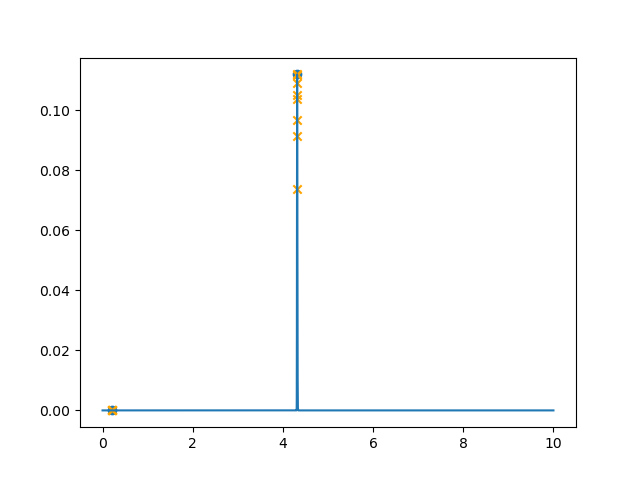

In [25]:
plt.figure()
i=np.random.randint(0,2000)

print(binary_peaks.shape)

all_ones = np.where(binary_peaks[i] > 0)[0]
all_ones.shape

plt.plot(x, signals[i])
plt.scatter(x[all_peaks[i]], signals[i][all_peaks[i]])

plt.scatter(x[all_ones], signals[i][all_ones], marker='x', color='orange')

plt.show()



In [18]:
def add_noise_by_percentage(signal, noise_percentage):
        """
        Add random noise to a NumPy array based on a percentage of the maximum signal value.

        Parameters:
            signal (numpy.ndarray): The original signal array.
            noise_percentage (float): Percentage of the maximum signal value to use as noise.

        Returns:
            noisy_signal (numpy.ndarray): The signal array with added noise.
        """
        # Find the maximum value in the signal
        max_value = np.max(np.abs(signal))

        # Calculate the noise standard deviation as a percentage of the max signal value
        noise_std = (noise_percentage / 100) * max_value

        # Generate random Gaussian noise with zero mean and calculated standard deviation
        noise = np.random.normal(0.005, noise_std, signal.shape)

        # Add the noise to the original signal
        noisy_signal = signal + noise

        return noisy_signal

noisy_signal = add_noise_by_percentage(signals, 0.2)

In [19]:
noisy_signal.shape

(2000, 11837)

In [156]:
ds = xr.Dataset(
    {
        "Intensities": (["pattern", "x"], noisy_signal),
        "BinaryArr": (["pattern", "x"], binary_peaks)
    },
    coords = {
        "pattern": np.arange(num_repetitions),
        "x": np.linspace(1, 10, x.shape[0])
    },
    attrs={
        "description": "Simulated Gaussian signals with labeled peaks, padded with 1s along FWHM",
        "min_d_rule": "Minimum distance between peaks = 2 * fwhm",
        "note": "Each pattern contains 5-10 Gaussian peaks. Used_means enforces peak spacing.",
        "params": "std_dev=np.random.uniform(0.02,0.1), mean=np.random.uniform(1,8) with seed=42, amp=np.random.uniform(0.1,1.0)",
        "noise": "True, 0.2%"
    }
)


In [157]:
gaussians = ds["Intensities"].values
binary = ds["BinaryArr"].values

(2000, 11837)


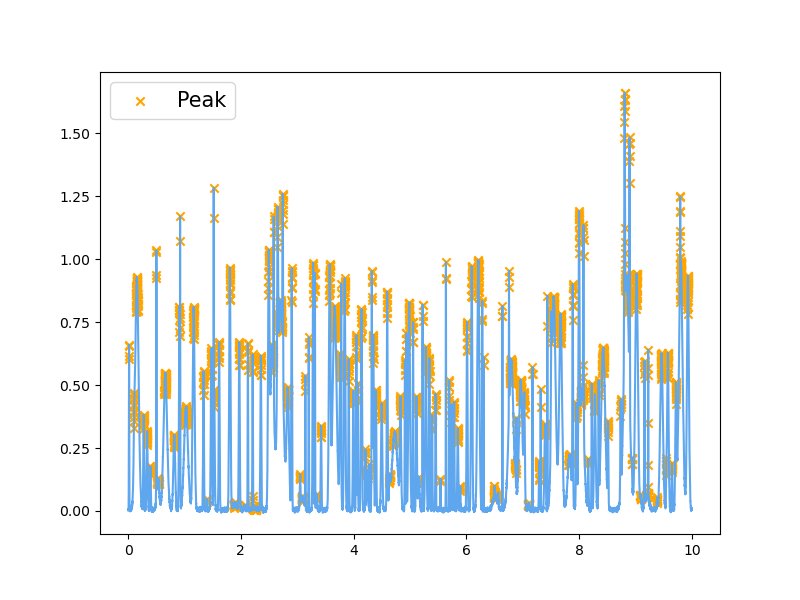

In [167]:
# Check that there is noise
plt.figure(figsize=(8,6))

i=np.random.randint(0,2000)
print(binary_peaks.shape)

all_ones = np.where(binary_peaks[i] > 0)[0]
all_ones.shape

plt.plot(x, gaussians[i], color='#5EA7EF')
# plt.scatter(x[all_peaks[i]], gaussians[i][all_peaks[i]])

plt.scatter(x[all_ones], gaussians[i][all_ones], marker='x', color='orange', label='Peak')

plt.legend(fontsize=15)
plt.show()


In [159]:
path = '../saved_data/'
file = f'gaussian_functions_{peak_density}_var_amp_noisy_11763.nc'

ds.to_netcdf(os.path.join(path, file))
with ZipFile(os.path.join(path,file.replace('.nc','.zip')), 'w', ZIP_DEFLATED) as zObject:
    zObject.write(os.path.join(path,file), arcname=file)
